In [72]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.timeseries import LombScargle
import scipy.signal as signal

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
tessfits = glob.glob('tess_fits_files/*fits')
tessfits

['tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits',
 'tess_fits_files/tess2019253231442-s0016-0000000259773610-0152-s_lc.fits']

Do both lc's separatly, then combine

Parameter('x_0', value=1.1440536789806446, unit=d) 0.0014835221402890583
Parameter('x_0', value=0.9776875854871951, unit=d) 0.0014543626077639998
Parameter('x_0', value=1.1543719348527006, unit=d) 0.0017872489512859827


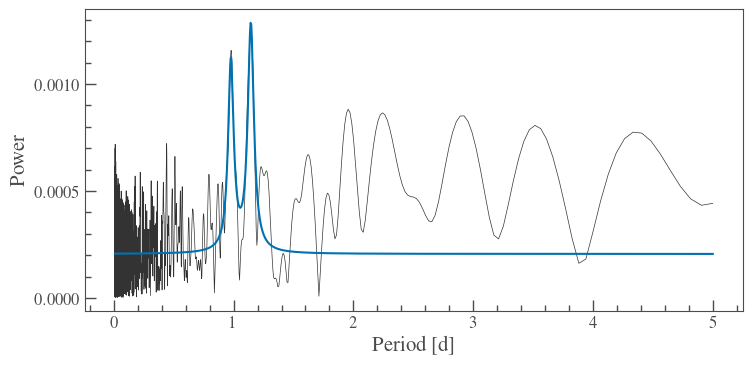

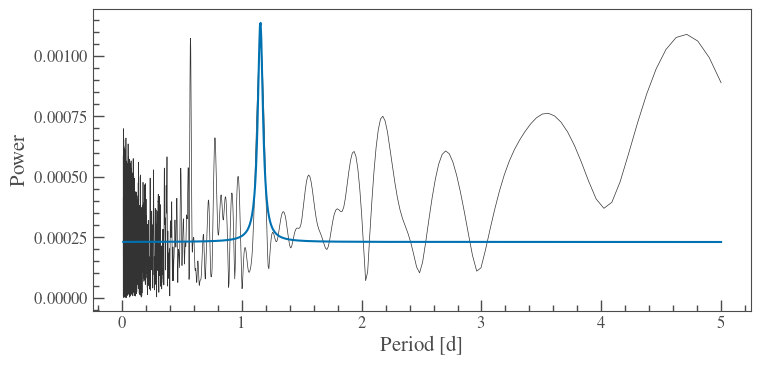

In [276]:
fitter = fitting.LevMarLSQFitter()

for i, ft in enumerate(tessfits):
    data = fits.getdata(ft, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    #plt.scatter(t, f)
    #plt.show()
    t, f, e = t[q==0], f[q==0], e[q==0]
    fit = np.polyval((np.polyfit(t,f,2)), t)
    #e=e/f
    f = f/fit
    e = e/fit
    #f, e = f/np.mean(f), e/np.mean(e)
    #f = f / np.mean(f)
   # e = e/f
   # f = (f/np.mean(f)*100)-100
    #e = e*f
    lc = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)
    if i == 0:
        lc15 = lc
    else:
        lc16= lc
    #lcf, trend = lc.flatten(1000001, return_trend=True)
    #lc.scatter()
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=0.01*u.day, maximum_period=5*u.day)
    pg.plot()
    l_init =  models.Lorentz1D(0.001, 1.15, fwhm=0.05)+models.Const1D(0)
    if i == 0:
        l_init += models.Lorentz1D(0.001, 0.9, fwhm=0.05)
    l_fit=fitter(l_init, pg.period, pg.power, maxiter=1000000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    #print(l_fit[0].fwhm)
    print(l_fit[0].x_0, fit_e[1])
    if i == 0:
        print(l_fit[2].x_0, fit_e[5])
   # plt.axvline(0.98)
    plt.plot(pg.period, l_fit(pg.period))

Maybe try and divide out the Earthshine?

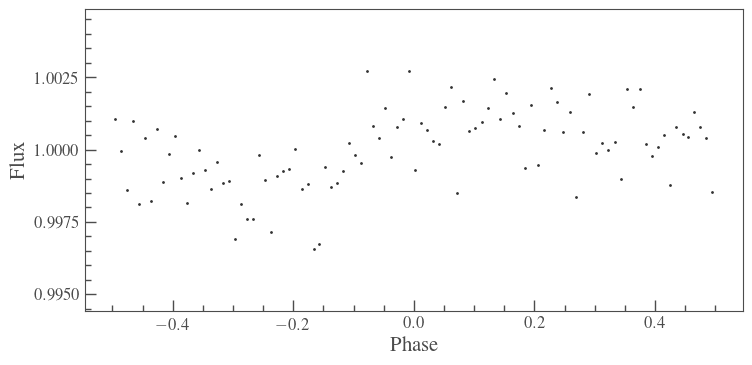

In [284]:
lc15.fold(0.9776875854871951).bin(180).scatter()

Model: CompoundModel185
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=1., frequency=1., phase=0.)>

    [1]: <Const1D(amplitude=1.)>
Parameters:
         amplitude_0      frequency_0       phase_0       amplitude_1
    --------------------- ----------- ------------------- -----------
    0.0011518684582612097         1.0 0.04804017606248577         1.0


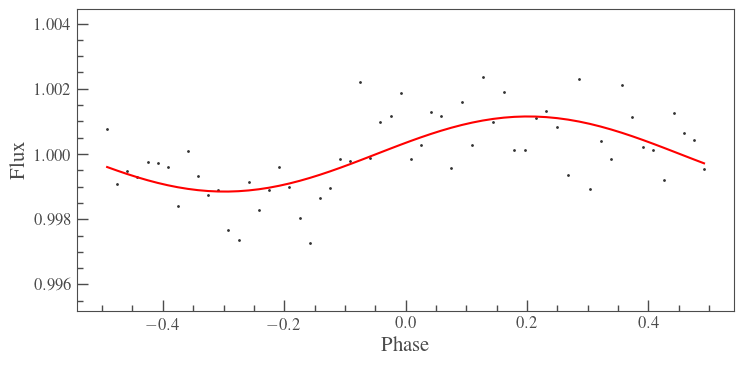

Model: CompoundModel186
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=1., frequency=1.02249489, phase=0.)>

    [1]: <Const1D(amplitude=1.)>
Parameters:
         amplitude_0          frequency_0           phase_0        amplitude_1
    ---------------------- ------------------ -------------------- -----------
    -0.0011200226562807782 1.0209290454313427 -0.18593390446495162         1.0


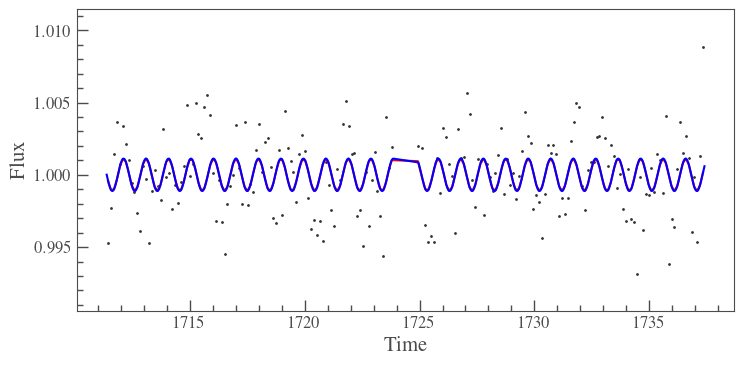

In [307]:
f_earth, e_earth = 0.978, 0.0015
fitter = fitting.LevMarLSQFitter()
lc_fold = lc15.fold(0.9776875854871951).bin(300)
lc_fold.scatter()
sin_mod =  models.Sine1D(amplitude=1, frequency=1, fixed={'frequency':1})+models.Const1D(1.0, fixed={'amplitude':1.0})
sin_fit = fitter(sin_mod, lc_fold.time, lc_fold.flux,  weights=1/lc_fold.flux_err, maxiter=100000)
print(sin_fit)
plt.plot(lc_fold.time, sin_fit(lc_fold.time), c='r')
plt.show()
                                                          
lc_bin = lc15.bin(90)
lc_bin.scatter()
sin_mod =  models.Sine1D(amplitude=1, frequency=1/f_earth, bounds={'frequency':[1/(f_earth-e_earth), 1/(f_earth+e_earth)]})+models.Const1D(1.0, fixed={'amplitude':1.0})
sin_fit = fitter(sin_mod, lc_bin.time, lc_bin.flux,  weights=1/lc_bin.flux_err, maxiter=100000)
print(sin_fit)
plt.plot(lc_bin.time, sin_fit(lc_bin.time), c='r') 
plt.plot(lc15.time, sin_fit(lc15.time), c='b')  

Parameter('x_0', value=1.1404351789292855, unit=d) 0.0014543936538094495


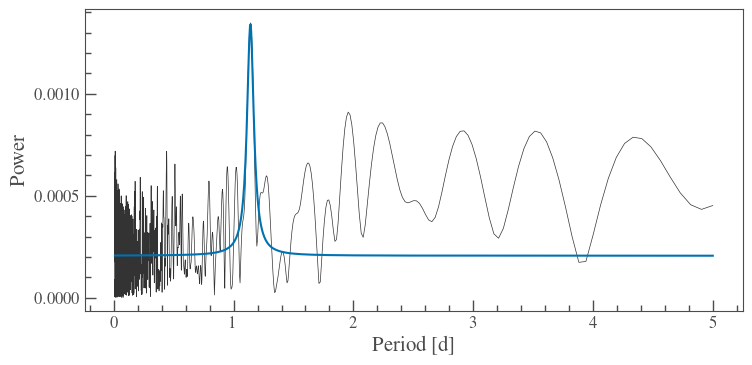

In [310]:
lc15_flat = lk.LightCurve(time=lc15.time, flux=lc15.flux/sin_fit(lc15.time), flux_err=lc15.flux_err/sin_fit(lc15.time))
pg_flat = lc15_flat.to_periodogram(oversample_factor=10,minimum_period=0.01*u.day, maximum_period=5*u.day)
pg_flat.plot()
l_init =  models.Lorentz1D(0.001, 1.15, fwhm=0.05)+models.Const1D(0)
  
l_fit=fitter(l_init, pg_flat.period, pg_flat.power, maxiter=1000000)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))

print(l_fit[0].x_0, fit_e[1])
plt.plot(pg_flat.period, l_fit(pg_flat.period))

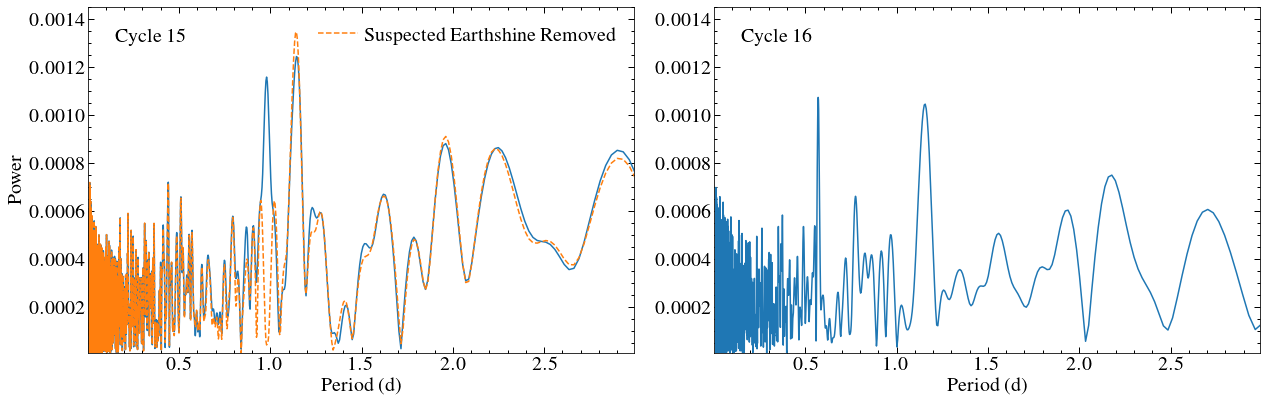

In [337]:
#make nice paper figure
plt.figure(figsize=(18,6))
max_p = 3
min_p = 0.01
ys=[0.00001, 0.00145]
xs=[0.001, 2.99]

plt.subplot(121)
pg15 = lc15.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)
pg_flat = lc15_flat.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)
plt.xlabel('Period (d)')
plt.ylabel('Power')
plt.annotate('Cycle 15', (0.05, 0.9), xycoords='axes fraction')
plt.ylim(ys[0], ys[1])
plt.xlim(xs[0], xs[1])
plt.plot(pg15.period, pg15.power)
plt.plot(pg_flat.period, pg_flat.power, ls='--', label='Suspected Earthshine Removed')
plt.legend()


plt.subplot(122)
pg16 = lc16.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)
plt.plot(pg16.period, pg16.power)
plt.annotate('Cycle 16', (0.05, 0.9), xycoords='axes fraction')
plt.xlabel('Period (d)')
plt.ylim(ys[0], ys[1])
plt.xlim(xs[0], xs[1])
plt.tight_layout()
plt.savefig('two_cycles_periodograms.pdf')

In [338]:
print(pg16.period_at_max_power)
pg16.period_at_max_power*2

0.5706890939641203 d


<Quantity 1.14137819 d>

Combine the lightcurves?

In [342]:
lc2c = lc15_flat.append(lc16)

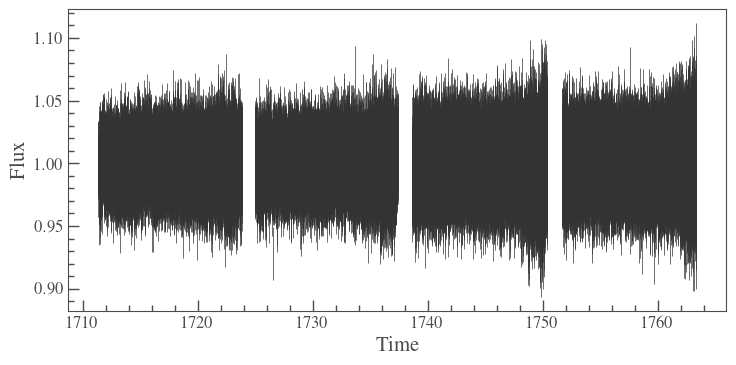

In [350]:
lc2c.errorbar()

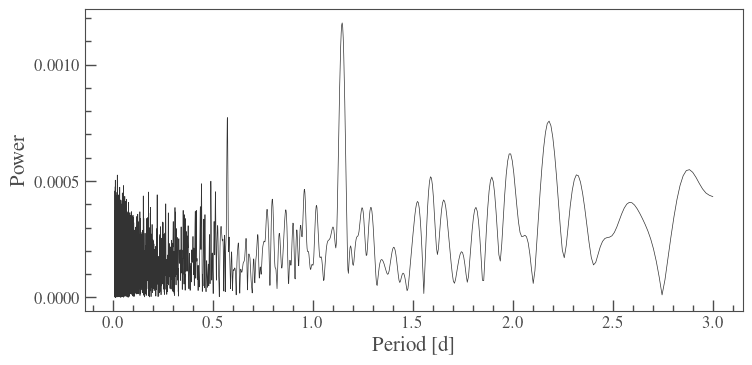

In [344]:
pg2c = lc2c.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)
pg2c.plot()

Trying the Hermes/Bell false alarm probability technique.

In [375]:
#n = 10000
#max_peak = []
#i = 0
#while i < n:
 #   i+=1
  #  fake_lc = np.random.normal(1, lc2c.flux_err,  len(lc2c.flux))
  #  fake_lc = lk.LightCurve(time=lc2c.time, flux=fake_lc)
  #  fake_pg = fake_lc.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)
  #  max_peak.append(max(fake_pg.power).value)

In [365]:
#print(len(max_peak))
#np.save('fake_peaks.txt', max_peak)

10000


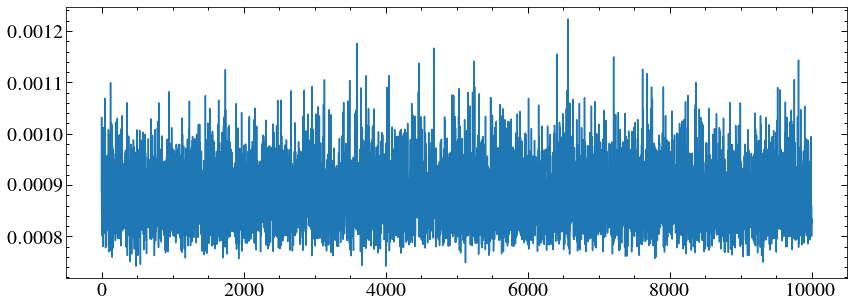

In [367]:
plt.plot(np.arange(len(max_peak)), max_peak)

In [376]:
#plt.hist(max_peak, bins=100, cumulative=-1)

In [381]:
fa99 = np.percentile(max_peak, 99)
print(fa99)

0.0010382394965667001


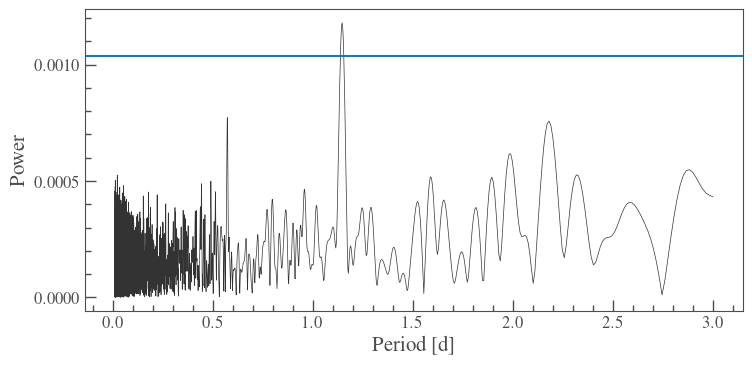

In [382]:
pg2c.plot()
plt.axhline(fa99)

Phew! Nice plot for paper

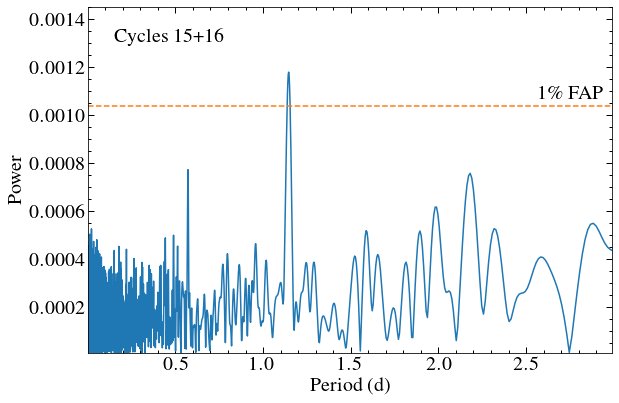

In [403]:
plt.figure(figsize=(9,6))

ys=[0.00001, 0.00145]
xs=[0.001, 2.99]


plt.xlabel('Period (d)')
plt.ylabel('Power')
plt.annotate('Cycles 15+16', (0.05, 0.9), xycoords='axes fraction')
plt.ylim(ys[0], ys[1])
plt.xlim(xs[0], xs[1])
plt.plot(pg2c.period, pg2c.power)
plt.axhline(fa99, ls='--', c='C1')

plt.xlabel('Period (d)')
plt.annotate('1\% FAP', (0.86, fa99+0.00003), xycoords=('axes fraction', 'data'))

plt.tight_layout()
plt.savefig('plots/both_ls_no_fit.pdf')